<h2>Persistence</h2>


 1. Persistence in LangGraph refers to the ability to save and restore the state of a workflow over time.

In [5]:
from langchain.chat_models import ChatOllama
from langgraph.graph import StateGraph, START, END
from typing import TypedDict
from langgraph.checkpoint.memory import InMemorySaver

In [3]:
model = ChatOllama(model='mistral-nemo:12b')

In [6]:
class JokeState(TypedDict):
    topic: str
    joke:str
    explanation: str

In [ ]:
def generate_joke(state: JokeState):
    prompt = f"generate a joke on the topic {state['topic']}"
    response = model.invoke(prompt).content
    
    return {'joke': response}

In [9]:
def generate_explanation(state: JokeState):
    prompt = f"write an explanation for the joke - {state['joke']}"
    response = model.invoke(prompt).content
    
    return {'explanation':response}

In [13]:
graph = StateGraph(JokeState)

graph.add_node('generate_joke', generate_joke)
graph.add_node('generate_explanation', generate_explanation)

graph.add_edge(START, 'generate_joke')
graph.add_edge('generate_joke', 'generate_explanation')
graph.add_edge('generate_explanation', END)

checkpointer = InMemorySaver()

workflow = graph.compile(checkpointer=checkpointer)

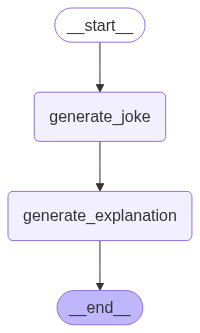

In [14]:
workflow

In [16]:
config = {'configurable':{'thread_id':"i"}}
workflow.invoke({'topic':'pizza'}, config=config)

{'topic': 'pizza',
 'joke': "Why did the pizza maker go broke? He just couldn't make enough dough. (And he didn't knead it!)",
 'explanation': 'This joke is a play on words, or a pun, involving two different meanings of the word "dough."\n\n1. In the context of pizza making, "dough" refers to the mixture of ingredients used to make the pizza base.\n2. In financial terms, "dough" can also mean money.\n\nThe humor comes from switching between these two meanings:\n\n- The setup "Why did the pizza maker go broke?" leads us to expect a reason related to finances or business failure.\n- The punchline "He just couldn\'t make enough dough" initially seems to refer to an inability to create sufficient pizza dough, which isn\'t surprising since pizza makers typically need plenty of dough for their products.\n- But then we remember the other meaning of "dough," and realize that the joke is actually saying he didn\'t earn enough money ("make enough dough") to keep his business afloat.\n\nThe addit

In [17]:
list(workflow.get_state_history(config))

[StateSnapshot(values={'topic': 'pizza', 'joke': "Why did the pizza maker go broke? He just couldn't make enough dough. (And he didn't knead it!)", 'explanation': 'This joke is a play on words, or a pun, involving two different meanings of the word "dough."\n\n1. In the context of pizza making, "dough" refers to the mixture of ingredients used to make the pizza base.\n2. In financial terms, "dough" can also mean money.\n\nThe humor comes from switching between these two meanings:\n\n- The setup "Why did the pizza maker go broke?" leads us to expect a reason related to finances or business failure.\n- The punchline "He just couldn\'t make enough dough" initially seems to refer to an inability to create sufficient pizza dough, which isn\'t surprising since pizza makers typically need plenty of dough for their products.\n- But then we remember the other meaning of "dough," and realize that the joke is actually saying he didn\'t earn enough money ("make enough dough") to keep his business 

<h3>Time Travel</h3>

In [18]:
import time

In [19]:
class CrashState(TypedDict):
    input:str
    step1:str
    step2:str
    step3:str

In [29]:
def step1(state: CrashState)->CrashState:
    print("step 1 executed...")
    return {'step1':'done', 'input':state["input"]}


def step2(state: CrashState)->CrashState:
    print("step 2 hanging..... now manually interrupt from the notebook toolbar (STOP Bbutton). ")
    time.sleep(30)
    return {'step1':'done'}

def step3(state: CrashState)->CrashState:
    print("step 3 executed...")
    return {'step1':'done'}

In [30]:
builder = StateGraph(CrashState)
builder.add_node('step1', step1)
builder.add_node('step2', step2)
builder.add_node('step3', step3)

builder.add_edge(START, 'step1')
builder.add_edge('step1', 'step2')
builder.add_edge('step2', 'step3')
builder.add_edge('step3', END)

checkpointer = InMemorySaver()

workflow = builder.compile(checkpointer=checkpointer)

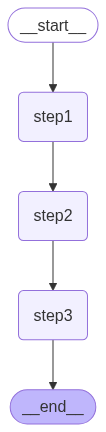

In [31]:
workflow

In [32]:
try:
    print("Running graph: Please manually interrupt during Step 2.....")
    workflow.invoke({"input":"start"}, config={"configurable":{"thread_id":"thread_1"}})
except KeyboardInterrupt:
    print("Kerner manually interrupted (crash simulated). ")

Running graph: Please manually interrupt during Step 2.....
step 1 executed...
step 2 hanging..... now manually interrupt from the notebook toolbar (STOP Bbutton). 
Kerner manually interrupted (crash simulated). 


In [33]:
workflow.get_state({"configurable":{"thread_id":"thread_1"}})

StateSnapshot(values={'input': 'start', 'step1': 'done'}, next=('step2',), config={'configurable': {'thread_id': 'thread_1', 'checkpoint_ns': '', 'checkpoint_id': '1f0816bf-0e1e-6fa2-8001-b703c0480159'}}, metadata={'source': 'loop', 'step': 1, 'parents': {}}, created_at='2025-08-25T04:28:25.130753+00:00', parent_config={'configurable': {'thread_id': 'thread_1', 'checkpoint_ns': '', 'checkpoint_id': '1f0816bf-0e14-6333-8000-98d56029ba6c'}}, tasks=(PregelTask(id='cd7c5c4e-2bc4-335e-7533-f84a34ab128c', name='step2', path=('__pregel_pull', 'step2'), error=None, interrupts=(), state=None, result=None),), interrupts=())

In [34]:
list(workflow.get_state_history({"configurable":{"thread_id":"thread_1"}}))

[StateSnapshot(values={'input': 'start', 'step1': 'done'}, next=('step2',), config={'configurable': {'thread_id': 'thread_1', 'checkpoint_ns': '', 'checkpoint_id': '1f0816bf-0e1e-6fa2-8001-b703c0480159'}}, metadata={'source': 'loop', 'step': 1, 'parents': {}}, created_at='2025-08-25T04:28:25.130753+00:00', parent_config={'configurable': {'thread_id': 'thread_1', 'checkpoint_ns': '', 'checkpoint_id': '1f0816bf-0e14-6333-8000-98d56029ba6c'}}, tasks=(PregelTask(id='cd7c5c4e-2bc4-335e-7533-f84a34ab128c', name='step2', path=('__pregel_pull', 'step2'), error=None, interrupts=(), state=None, result=None),), interrupts=()),
 StateSnapshot(values={'input': 'start'}, next=('step1',), config={'configurable': {'thread_id': 'thread_1', 'checkpoint_ns': '', 'checkpoint_id': '1f0816bf-0e14-6333-8000-98d56029ba6c'}}, metadata={'source': 'loop', 'step': 0, 'parents': {}}, created_at='2025-08-25T04:28:25.126341+00:00', parent_config={'configurable': {'thread_id': 'thread_1', 'checkpoint_ns': '', 'checkp

In [35]:
final_state = workflow.invoke(None, config={"configurable":{"thread_id":"thread_1"}})
print("Final state", final_state)

step 2 hanging..... now manually interrupt from the notebook toolbar (STOP Bbutton). 
step 3 executed...
Final state {'input': 'start', 'step1': 'done'}


<h3>Streaming<h3>
1. In LLMs streaming means the model starts sending tokens(words) as soon as they're generated, instead of waiting for the entire response to be ready before returning it.

**Why Streaming.?**
1. Faster response time - low drop-off rates.
2. Mimic human like conversation(Builds trust, feels alive and keeps the user engaged).
3. Important for Multi-modal UIs.
4. Better UX for long output such as code.
5. You can cancel mideway saving tokens.
6. You can interleave UI updates, e.g., show "thinking...", show tools results.

**Generators**

In Python, a generator is a special type of iterator that allows you to generate values on the fly, one at a timem using the yield keyword instead of return.

<h3>What is LangSmith<h3>

1. LangSmith is a unified observability & evaluation platform where teams can debug, test and monitor AI app performance.

In [40]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict, Annotated
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_ollama import ChatOllama
from langgraph.graph.message import add_messages

from langgraph.prebuilt import ToolNode, tools_condition
from langchain_community.tools import DuckDuckGoSearchRun
from langchain_core.tools import tool

import requests
import random

In [38]:
model = ChatOllama(model='gpt-oss:20b')

In [42]:
search_tool = DuckDuckGoSearchRun(region="us-en")

@tool
def calculator(first_num: float, second_num: float, operation:str)->dict:
    """
    Perform a basic arithmetic operation on two numbers.
    Supported operations: add, sub, mul, div.
    """
    
    try:
        if operation=="add":
            result = first_num+second_num
        elif operation=="sub":
            result = first_num-second_num
        elif operation=="mul":
            result = first_num*second_num
        elif operation=="div":
            if second_num==0:
                return {"error": "Division by zero is not allowed"}
            result = first_num/second_num
        else:
            return {'error': f"Unsupported operation '{operation}'"}
        
        return {"first_num":first_num, "second_num":second_num, "operation":operation,
                "result":result}
    except Exception as e:
        return {"error": str(e)}
        
        

In [43]:
tools = [search_tool, calculator]
llm_with_tools = model.bind_tools(tools)

In [44]:
class ChatState(TypedDict):
    messages:Annotated[list[BaseMessage], add_messages]
    

In [47]:
def chat_node(state: ChatState):
    """
    LLM node that may answer or request a tool call.
    """
    messages = state['messages']
    response = llm_with_tools.invoke(messages)
    return {'messages': [response]}


tool_node= ToolNode(tools)

In [56]:
graph = StateGraph(ChatState)
graph.add_node("chat_node", chat_node)
graph.add_node("tools", tool_node)

In [57]:
graph.add_edge(START, "chat_node")

graph.add_conditional_edges("chat_node", tools_condition)
graph.add_edge("tools", "chat_node")


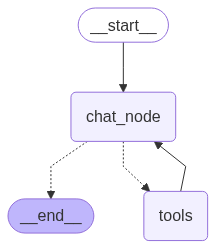

In [58]:
chatbot = graph.compile()
chatbot

In [59]:
out = chatbot.invoke({"messages":[HumanMessage(content="Hello!")]})
print(out['messages'][-1].content)

Hello! How can I help you today?


In [67]:
out = chatbot.invoke({"messages":[HumanMessage(content="what is 8+5.?")]})
print(out['messages'][-1].content)

The result of 8 + 5 is **13**.
